<h1 style="color:orange;text-align:center;font-family:courier;font-size:220%">Unsupervised Representation Learning - SimCLR</h1>
<h3 style="color:orange;text-align:center;font-family:courier;font-size:110%"><u>Why are we doing it?</u></h3>
<p style="text-align:center"><img src="assets/1_7O5f7-9geTlqejOm_uKRhg.png" alt="ps" height="200" width="540"/>
<h3 style="color:green;text-align:center;font-family:courier;font-size:90%">Unsupervised Learning helps us train models without labeling data, here lets run an experiment on CIFAR10 dataset without lableling it and learn the data internal representations and cluster it, the base paper reference is here <a href=https://arxiv.org/abs/2002.05709>SimCLR</a></p>


Key Takeaways:
* Train your own representation learner.
* The project is for experimental and research purpose and each module can be customized.
* SimCLR strongly suggests data augumentation plays a key role on rich feature extraction and convergence.
* An initial idea of what types of data you are training will enable what data augumentation can be added or removed.
* The fundamental idea is explained using Images but core concept can be extended to any domain audio,text etc... with modification in the  sampling and loss function


In [17]:
import os
from tqdm import tqdm
from glob import glob

import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

dataset_root_path = '../dataset/cifar10x64/'
resize_with_aspect = False
standard_h,standard_w = 64,64 #this size for adjusting viable crop sizes.
final_h,final_w = 64,64 #this is final size of image before entering Model.
random_crop_min,random_crop_max = 40,62 #crop dimensions
batch_size = 32

### Function for data augumentation and data pipeline
#### Two Data Augumentations are primarily used from the paper.
* Geometrical Transformations
* Colour Jitter

In [3]:
def img_to_array(image_path):
    imbyte = tf.io.read_file(image_path)
    im_matrix = tf.io.decode_jpeg(imbyte,channels=3)
    if resize_with_aspect:
        im_matrix = tf.image.resize_with_pad(im_matrix,target_height=standard_h,
                                         target_width=standard_w)
    im_matrix = tf.image.resize(im_matrix,size=(standard_h,standard_w),method="bilinear")
    return im_matrix/255


def _color_jitter(x,delta=0.7,s=1.0):
    x = tf.image.random_brightness(x, max_delta=delta * s)
    x = tf.image.random_contrast(x, lower=1 - delta * s, upper=1 + delta * s)
    x = tf.image.random_saturation(x, lower=1 - delta * s, upper=1 + delta * s)
    x = tf.image.random_hue(x, max_delta=0.2 * s)
    x = tf.clip_by_value(x, 0, 1)
    return x

def _affine_transformation(x,rot_90_prob=0.8,flip_vert_prob=0.8,flip_hor_prob=0.5):
    x = tf.cond(tf.random.uniform([],0,1)>flip_hor_prob, lambda:tf.image.random_flip_left_right(x),lambda:x)
    x = tf.cond(tf.random.uniform([],0,1)>flip_vert_prob, lambda:tf.image.random_flip_up_down(x),lambda:x)
    x = tf.cond(tf.random.uniform([],0,1)>rot_90_prob, lambda:tf.image.rot90(x),lambda:x)
    return tf.cast(x,tf.float32)
    
def crop_affine_(imarray):
    size_to_crop = np.random.randint(random_crop_min,random_crop_max,1)[0]
    im_matrix   = tf.image.random_crop(imarray,(size_to_crop,size_to_crop,3))
    im_matrix   = tf.image.resize(im_matrix,(final_h,final_w))
    im_matrix   = _affine_transformation(im_matrix,rot_90_prob=0.8,
                               flip_vert_prob=0.9,
                               flip_hor_prob=0.5)
    return im_matrix


def augument(image_path):
    imjpg = img_to_array(image_path=image_path)
    imjpg = crop_affine_(imjpg)
    imjpg = tf.cond(tf.greater(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),0.6),
                    lambda:_color_jitter(imjpg,delta=0.1,s=1.0),lambda :imjpg)
    return imjpg


def testaugument(image_path):
    imjpg = img_to_array(image_path=image_path)
    return imjpg

files = glob(f"{dataset_root_path}/*")
dataset = tf.data.Dataset.from_tensor_slices(files)
traindata = dataset.map(lambda x:(augument(x),augument(x)),num_parallel_calls=tf.data.AUTOTUNE)
traindata = traindata.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

### Visualize Augumentaion Intensity

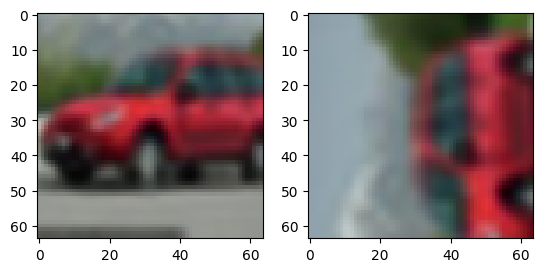

In [5]:
for x,y in traindata.take(2):
    a = x[28]
    b = y[28]
    fig,arrax = plt.subplots(1,2)
    arrax[0].imshow((a*255.).numpy().astype(np.int16))
    arrax[1].imshow((b*255.).numpy().astype(np.int16))
    break

### Define the Model and Loss function
* The model backbone can be any (here ResNet) and we choose our projection vector size (Vector size : Impacts the performance).
* We use ntxent loss (Normalized Temperature-Scaled Cross entropy loss).
<p style="text-align:center"><img src="assets/loss.png" alt="ps" height="200" width="540"/>

In [6]:
class FeatureModel(tf.keras.models.Model):
    def __init__(self,project_dim=128):
        super(FeatureModel, self).__init__()
        self.project_dim = project_dim
        self.basemodel = tf.keras.applications.ResNet50(include_top=False,
                                                        weights=None,
                                                        input_shape=(None,None,3))
        self.global_avg_pool2d = tf.keras.layers.GlobalAvgPool2D()
        self.projection = tf.keras.Sequential([tf.keras.layers.Dense(project_dim),
                                               tf.keras.layers.Activation("gelu"),
                                               tf.keras.layers.Dense(project_dim)])

    def call(self,x):
        feat = self.global_avg_pool2d(self.basemodel(x))
        proj = self.projection(feat)
        return feat,proj


def ntxent_loss(projection_a,projection_b,temp=0.1):
    batch_size = tf.shape(projection_a)[0]
    norm_a = tf.math.l2_normalize(projection_a,axis=-1)
    norm_b = tf.math.l2_normalize(projection_b,axis=-1)
    logits = tf.matmul(norm_a,norm_b,transpose_b=True)/temp
    pred = tf.nn.softmax(logits,)
    target = tf.eye(batch_size,batch_size,dtype=logits.dtype)
    loss1 = tf.losses.categorical_crossentropy(target,pred,from_logits=False)
    loss2= tf.losses.categorical_crossentropy(target,tf.transpose(pred),from_logits=False)
    final_loss  = (loss1+loss2)/2
    return final_loss

### Train the model 
* Gradient Accumulation provided me better results, it is indeed proven!

In [7]:
nnet = FeatureModel(project_dim=256)
optimizer = tf.keras.optimizers.Adam(7e-5,gradient_accumulation_steps=2)
for epoch in range(36):
    print("epoch: ",epoch)
    epoch_loss=0
    for step,(view_a,view_b) in tqdm(enumerate(traindata)):
        with tf.GradientTape() as tape:
            view1_embed,view1_proj = nnet(view_a)
            view2_embed,view2_proj = nnet(view_b)
            loss_ = tf.reduce_sum(ntxent_loss(view1_proj,view2_proj,temp=0.1))
        gradients = tape.gradient(loss_, nnet.trainable_variables)
        optimizer.apply_gradients(zip(gradients, nnet.trainable_variables))
        epoch_loss+=loss_
    print(f"epoch loss : {epoch_loss/(len(files)//batch_size)}")
    nnet.save_weights("cifar10x64_gelu.weights.h5")

### Model Testing
* Create the vector projections for all the samples
* Use t-SNE for dimensionality reduction for visualuzation (2048 dim to 2 dim)
* Cluster the data for visualzing how each data point is isolated.

In [18]:
samples_for_test = sorted(glob(f"{dataset_root_path}/*"))[:]
dataset = tf.data.Dataset.from_tensor_slices(samples_for_test)
testdata = dataset.map(lambda x:(testaugument(x),testaugument(x)),num_parallel_calls=tf.data.AUTOTUNE)
testdata = testdata.batch(batch_size=64).prefetch(tf.data.AUTOTUNE)
vectors  = nnet.predict(x=testdata)
embeddings_computed=vectors[0]

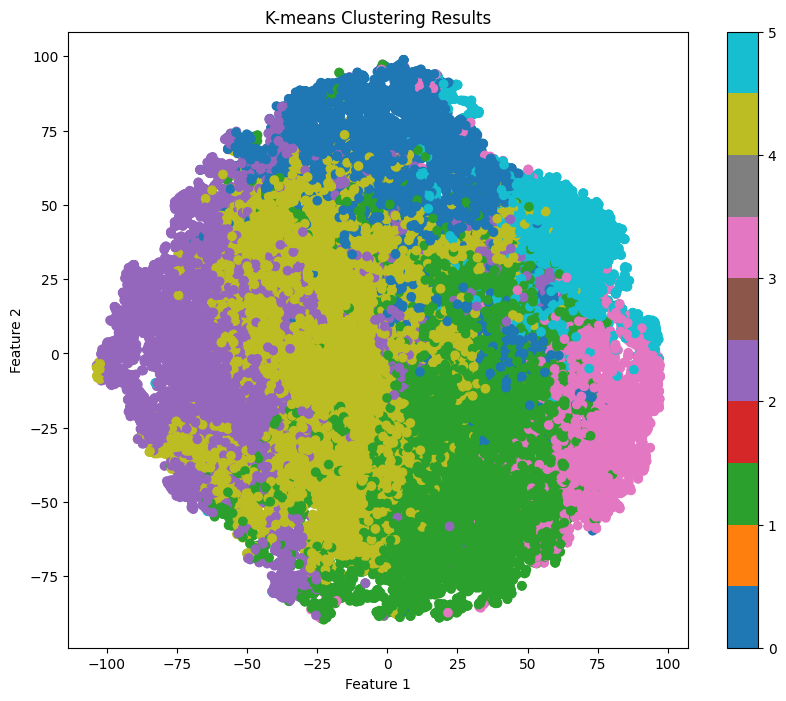

In [15]:
num_clusters = 6
data = embeddings_computed[:,:]
tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(data)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(data)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=clusters, cmap='tab10')
plt.colorbar(scatter)
plt.title('K-means Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()